# Recursive feature addition

- [Feature Selection in Machine Learning Book](https://www.trainindata.com/p/feature-selection-in-machine-learning-book)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from feature_engine.selection import RecursiveFeatureAddition

In [2]:
# load dataset

X, y = load_breast_cancer(return_X_y=True, as_frame=True)

# Separate data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
293,11.85,17.46,75.54,432.7,0.08372,0.05642,0.026880,0.022800,0.1875,0.05715,...,13.06,25.75,84.35,517.8,0.1369,0.17580,0.13160,0.09140,0.3101,0.07007
332,11.22,19.86,71.94,387.3,0.10540,0.06779,0.005006,0.007583,0.1940,0.06028,...,11.98,25.78,76.91,436.1,0.1424,0.09669,0.01335,0.02022,0.3292,0.06522
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.144000,0.097910,0.1752,0.05533,...,23.69,38.25,155.00,1731.0,0.1166,0.19220,0.32150,0.16280,0.2572,0.06637
278,13.59,17.84,86.24,572.3,0.07948,0.04052,0.019970,0.012380,0.1573,0.05520,...,15.50,26.10,98.91,739.1,0.1050,0.07622,0.10600,0.05185,0.2335,0.06263
489,16.69,20.20,107.10,857.6,0.07497,0.07112,0.036490,0.023070,0.1846,0.05325,...,19.18,26.56,127.30,1084.0,0.1009,0.29200,0.24770,0.08737,0.4677,0.07623


In [3]:
# the ML model for which we want to select features

model = GradientBoostingClassifier(
    n_estimators=5,
    random_state=10,
)

## Feature-engine

In [4]:
rfa = RecursiveFeatureAddition(
    estimator=model,  
    scoring='roc_auc',  
    threshold=0.0001,  
    cv=2, 
)

rfa.fit(X_train, y_train)

RecursiveFeatureAddition(cv=2,
                         estimator=GradientBoostingClassifier(n_estimators=5,
                                                              random_state=10),
                         threshold=0.0001)

In [5]:
# Performance of model trained using all features

rfa.initial_model_performance_

np.float64(0.9669312143006297)

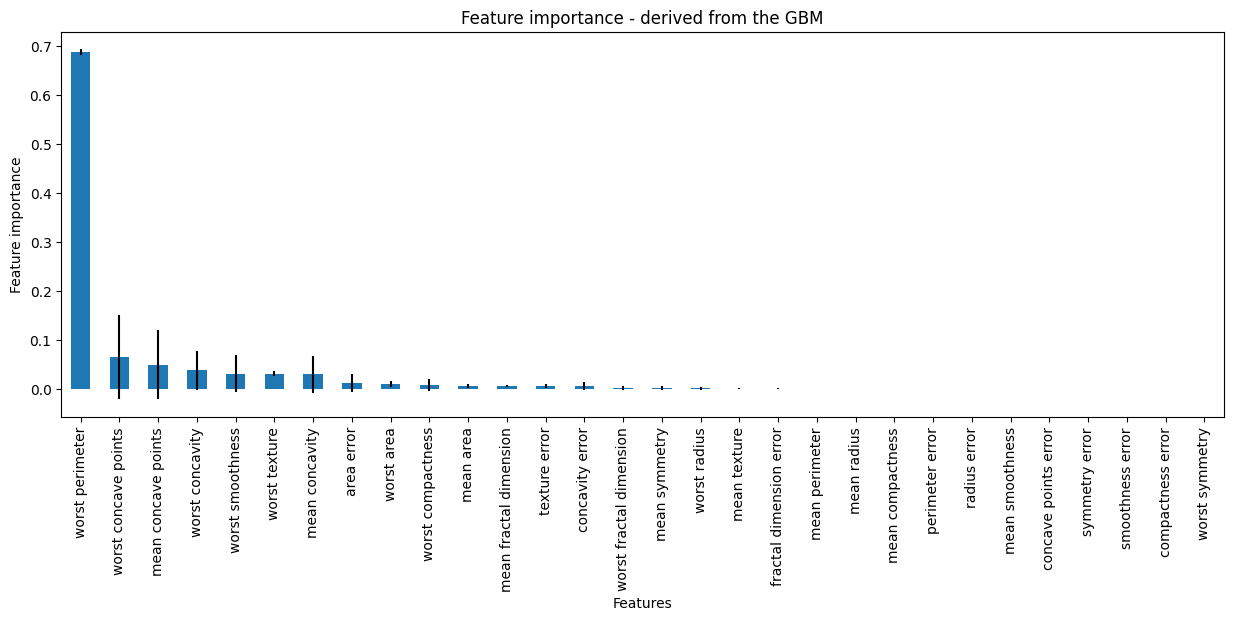

In [6]:
# Feature importance derived from initial model
r = pd.concat([
    pd.Series(rfa.feature_importances_),
    pd.Series(rfa.feature_importances_std_)
], axis=1
)
r.columns = ['mean', 'std']

r['mean'].plot.bar(yerr=[r['std'], r['std']], subplots=True, figsize=(15,5))

plt.title("Feature importance - derived from the GBM")
plt.ylabel('Feature importance')
plt.xlabel('Features')
plt.show()

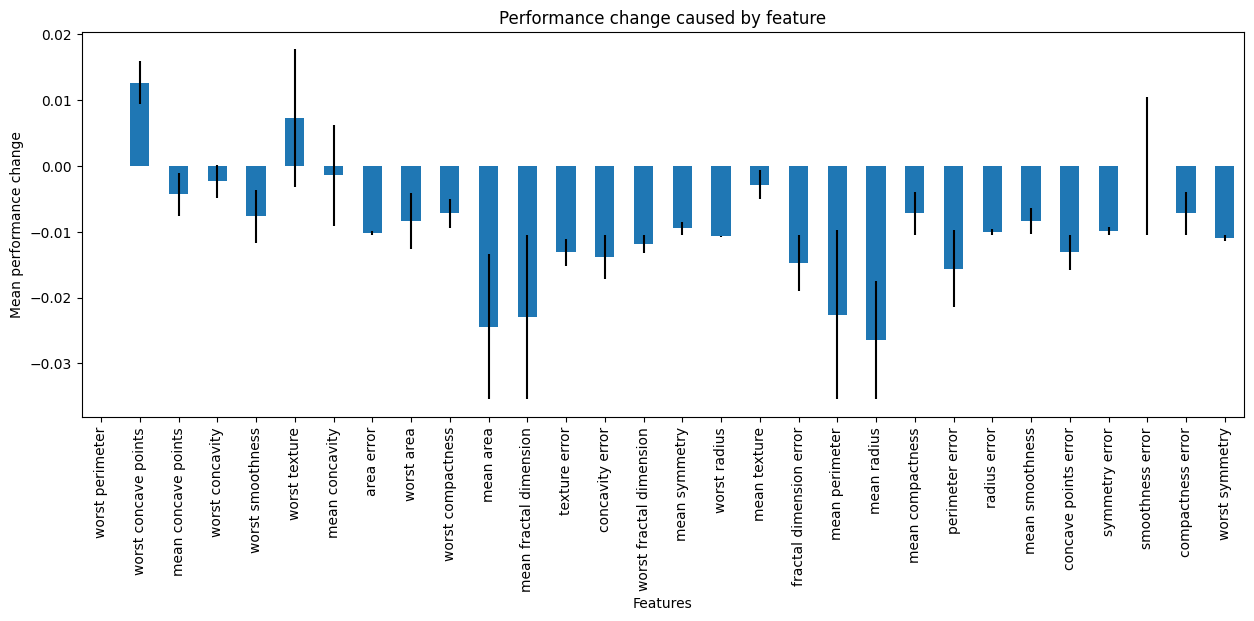

In [10]:
# Changes in performance after adding each feature

r = pd.concat([
    pd.Series(rfa.performance_drifts_),
    pd.Series(rfa.performance_drifts_std_)
], axis=1
)
r.columns = ['mean', 'std']

r['mean'].plot.bar(yerr=[r['std'], r['std']], subplots=True, figsize=(15,5))

plt.title("Performance change caused by feature")
plt.ylabel('Mean performance change')
plt.xlabel('Features')
plt.show()

In [8]:
# the features to remove

rfa.features_to_drop_

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst radius',
 'worst area',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst symmetry',
 'worst fractal dimension']

In [11]:
# reduce dataset

X_train_t = rfa.transform(X_train)
X_test_t = rfa.transform(X_test)

X_test_t.head()

,worst texture,worst perimeter,worst concave points
512,29.66,113.30,0.20510
457,34.23,91.29,0.06005
439,19.31,96.53,0.08216
298,25.26,105.80,0.07530
37,22.81,84.46,0.05013


The transformed datasets contains the most important feature plus those 2 that caused an increase in model performance.

Let's train a model with the selectead features and compare its performance to the model trained using the entire dataset:

In [15]:
model.fit(X_train_t, y_train)

roc_auc_score(y_test, model.predict_proba(X_test_t)[:, 1])

np.float64(0.9922431865828093)

As we see, the model trained with 3 features has at least as good performance, if not better, than the model trained using the entire dataset.

## Manual

In [10]:
# Train model using all features
model.fit(X_train, y_train)

# Calculate the roc-auc in the test set
y_pred_test = model.predict_proba(X_test)[:, 1]
roc_full = roc_auc_score(y_test, y_pred_test)

print(f'ROC AUC full dataset = {roc_full}')

ROC AUC full dataset = 0.9731656184486374


In [11]:
# rank features by importance

features = pd.Series(model.feature_importances_,
                     index=X_train.columns).sort_values(ascending=False)

features.head()

mean concave points    0.754473
worst area             0.049151
worst radius           0.044597
worst texture          0.035570
worst perimeter        0.029786
dtype: float64

In [12]:
# make list of ordered features

features = list(features.index)

In [13]:
# train model using only the most important feature

model_one_feature = clone(model)
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict_proba(
    X_test[features[0]].to_frame())[:, 1]

roc_first = roc_auc_score(y_test, y_pred_test)

print(f'ROC AUC one feature = {roc_first}')

ROC AUC one feature = 0.9548218029350105


In [14]:
tol = 0.0001

# the features we should keep
features_to_keep = [features[0]]

# we loop over all the features, based on their importance:
for feature in features[1:]:

    # initialise model
    model_int = clone(model)

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test[features_to_keep + [feature] ])[:, 1]

    # calculate the new roc-auc
    roc_int = roc_auc_score(y_test, y_pred_test)

    # determine the increase in the roc-auc
    diff_roc = roc_int - roc_first

    # assess the change in the roc-auc
    if diff_roc >= tol:
        # if the increase in the roc is bigger than the threshold
        # we keep the feature and re-adjust the roc-auc to the new value
        # considering the added feature
        roc_first = roc_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)

print(f'number of features to keep: {len(features_to_keep)}')

number of features to keep: 4


In [15]:
# finally, let's determine the performance of a model 
# trained on the selected features

model_final = clone(model)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print(f'ROC AUC selected features = {roc_final}')

ROC AUC selected features = 0.9919287211740042
